# **Baseline results**

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import visualization

In [2]:
MEAS_ROOT = "../02_data/"
MEAS_CASES = ["mix10", "mix25", "mix50"]
SEEDS = [42, 1812, 9698, 424, 820, 75, 98, 65535, 16383, 513]

## Occupancy

In [3]:
def combine_occups(meas_series, meas_name, seeds):
    meas_path = f"{MEAS_ROOT}/{meas_series}/{meas_name}"
    occupancies = pd.DataFrame()
    for seed in seeds:
        occup_df = pd.read_csv(f"{meas_path}/{seed}/occupancy.csv")
        occup_df["seed"] = seed
        occupancies = pd.concat([occupancies, occup_df])
    return occupancies

In [4]:
def plot_occupancy(occup_df):
    occup_filt = occup_df #no warning
    occup_filt["parking_id"] = occup_df["parking_id"].str.strip("pa")
    
    mean_occupancy = occup_filt.groupby("parking_id").mean()["occupancy"]
    occup_plot = {}
    for pid in mean_occupancy.index:
        occup_plot[pid] = mean_occupancy[pid]
    
    fig, ax = visualization.plot_network_probs(
        "../01_simulation/02_scenario/grid.net.xml",
        occup_plot,
        cmap="RdBu", #p_min = 0.0,  p_max=1.2
    )
    return fig, ax

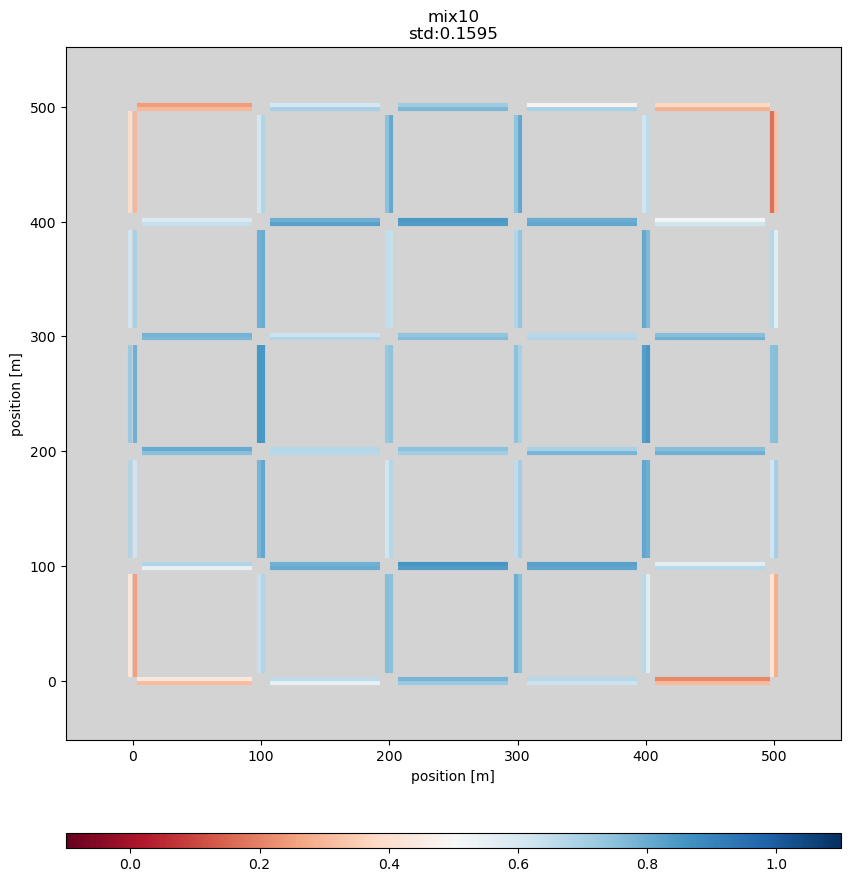

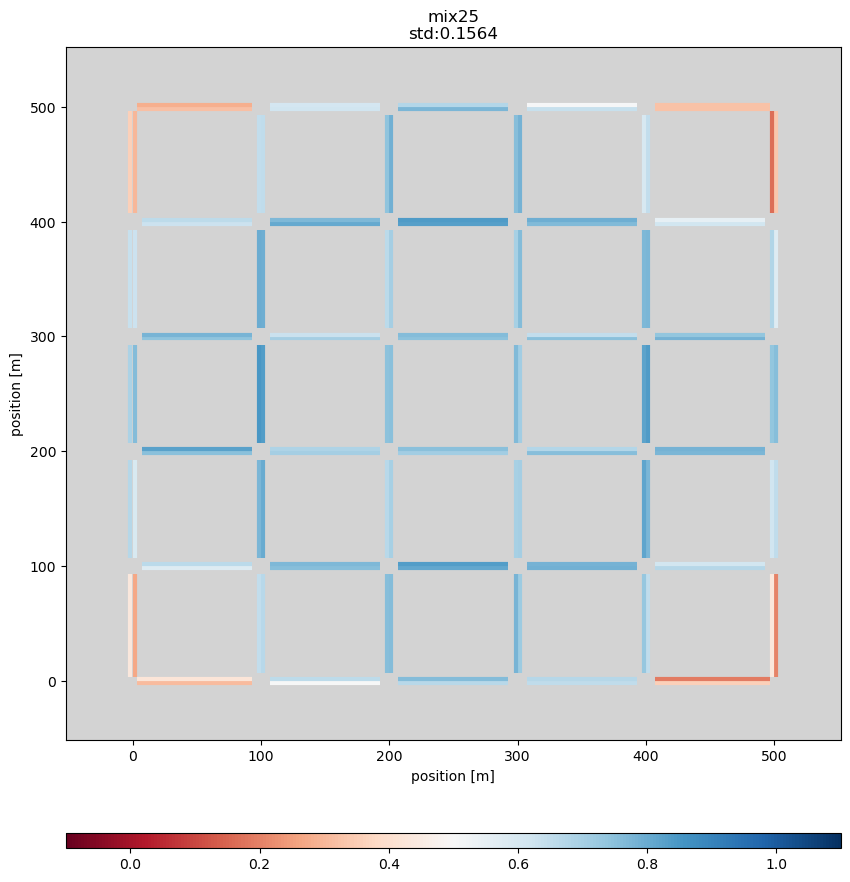

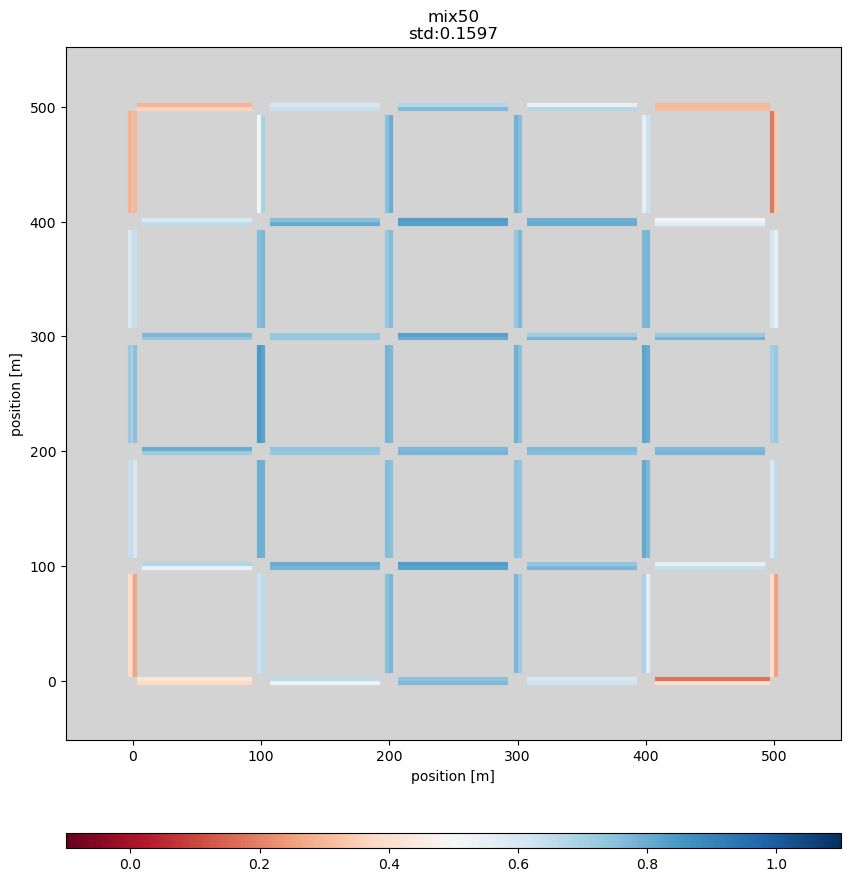

In [5]:
for case in MEAS_CASES:
    occup = combine_occups(case, "baseline", SEEDS)
    plot_occupancy(occup)
    std = np.std(occup.groupby("parking_id").mean()["occupancy"])
    plt.title(
        f"{case}\nstd:{std:.4}"
    )

## Vehicle data

In [12]:
def read_vehicle_data(meas_series, meas_name, seeds, col_name, col_value):
    meas_path = f"{MEAS_ROOT}/{meas_series}/{meas_name}"
    veh_data_comb = pd.DataFrame()
    for seed in seeds:
        with open(f"{meas_path}/{seed}/veh_results.json") as f:
            veh_res = json.load(f)
        veh_data = pd.DataFrame.from_dict(veh_res, orient="index")
        veh_data["seed"] = seed
        veh_data.index = veh_data.index.astype(int)

        trip_df = pd.read_xml(f"{meas_path}/{seed}/vehicle_trips.xml", xpath = "tripinfo")
        trip_df["id"] = trip_df["id"].astype(int)

        vd = pd.merge(left=trip_df, right=veh_data, left_on="id", right_index=True)
        
        vd[col_name] = [col_value]*len(vd)
        
        veh_data_comb = pd.concat([veh_data_comb, vd])
    
    #veh_data_comb["prolonged_distance"] = np.clip(veh_data_comb["routeLength"] - veh_data_comb["original_distance"], a_min = 0, a_max=None)
    return veh_data_comb

In [13]:
def get_mean_values(veh_data):
    return {
        "avg_paid_price": np.mean(veh_data["paid_price"]),
        "avg_prolonged_distance": np.mean(veh_data["parking_distance"]),
        "avg_total_parking_revenue": np.mean(veh_data.groupby("seed").sum()["paid_price"]),
        "avg_n_reroutes": np.mean(veh_data["rerouteNo"])
    }

In [14]:
print("=========BASELINE=========")
for meas_case in MEAS_CASES:
    veh_data = read_vehicle_data(meas_case, "baseline", SEEDS, "penetration", "baseline")
    print(meas_case, get_mean_values(veh_data))

=========BASELINE=========
mix10 {'avg_paid_price': 0.6044704861111111, 'avg_prolonged_distance': 125.43879131944442, 'avg_total_parking_revenue': 6963.5, 'avg_n_reroutes': 0.4639756944444444}
mix25 {'avg_paid_price': 0.6081336805555555, 'avg_prolonged_distance': 114.97679105902778, 'avg_total_parking_revenue': 7005.7, 'avg_n_reroutes': 0.4300954861111111}
mix50 {'avg_paid_price': 0.6139419613017474, 'avg_prolonged_distance': 114.65932482052793, 'avg_total_parking_revenue': 7072.55, 'avg_n_reroutes': 0.42932291666666667}


## Traffic flow

In [15]:
def read_flow(meas_series, meas_name, seeds):
    flow_series = []
    for seed in SEEDS:
        flow_df = pd.read_xml(f"{MEAS_ROOT}/{meas_series}/{meas_name}/{seed}/detector_data.out.xml", xpath="interval")
        flow_series.append(flow_df.groupby("begin")["flow"].mean().values)
    flows = np.array(flow_series)
    return flows

Text(0.5, 1.0, 'traffic flow\nbaseline')

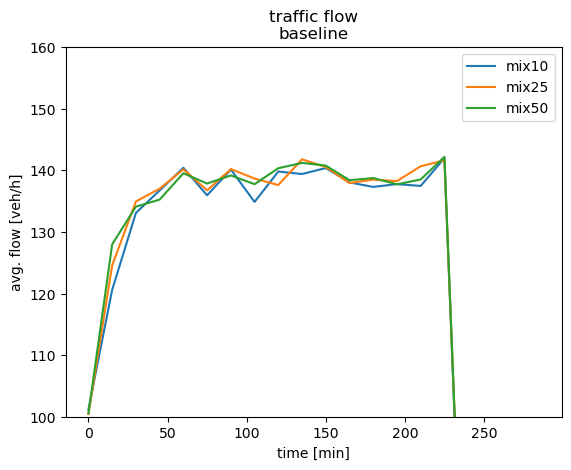

In [16]:
for meas_case in MEAS_CASES:
    flows = read_flow(meas_case, "baseline", SEEDS)
    flow = np.mean(flows, axis=0)
    plt.plot(np.arange(0, 15*4*5, 15), flow, label=meas_case)
    
plt.legend()
plt.xlabel("time [min]")
plt.ylabel("avg. flow [veh/h]")
plt.ylim(100, 160)
plt.title("traffic flow\nbaseline")